In [1]:
%matplotlib inline

import pickle

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec

sns.set_context("poster")
sns.set_style("white")
mpl.rcParams["text.usetex"] = True
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.serif"] = ["Computer Modern"]

# Setup

In [2]:
opt_titles = [
    ("eve", "Eve"),
    ("adam", "Adam"),
    ("adamax", "Adamax"),
    ("sgdnesterov", "SGD Nesterov"),
    ("rmsprop", "RMSprop"),
    ("sgd", "SGD"),
    ("adagrad", "Adagrad"),
    ("adadelta", "Adadelta"),
]
colors = sns.xkcd_palette(["amber", "red", "greyish", "windows blue", "faded green", "dusty purple", "black", "light blue"])

In [3]:
def plot_losses(model, dataset, ax, loss_ylim=None, nolrg=False):
    min_min_loss, min_max_loss = np.inf, np.inf
    for i, (opt, title) in enumerate(opt_titles):
        try:
            with open("../data/{}/{}/{}.pkl".format(model, dataset, opt), "rb") as f:
                data = pickle.load(f)
        except FileNotFoundError:
            continue
        loss_history = data["best_loss_history"]

        if .95*np.min(loss_history) < min_min_loss:
            min_min_loss = .95*np.min(loss_history)
        if .95*np.max(loss_history) < min_max_loss:
            min_max_loss = .95*np.max(loss_history)

        if nolrg is False:
            lr_str = "($\\alpha\\ 10^{{{}}}$".format(int(np.round(np.log10(data["best_opt_config"]["lr"]))))
            try:
                decay = data["best_decay"]
                if np.isclose(decay, 0):
                    decay_str = ", $\\gamma\\ 0)$"
                else:
                    decay_str = ", $\\gamma\\ 10^{{{}}})$".format(int(np.round(np.log10(decay))))
            except KeyError:
                decay_str = ")"
        else:
            lr_str = decay_str = ""
        ax.semilogy(range(1, len(loss_history) + 1), loss_history, label="{} {}{}".format(title, lr_str, decay_str), color=colors[i], linewidth=3)

    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    if loss_ylim is not None:
        ax.set_ylim(*loss_ylim)
        ax.set_yticks(np.logspace(np.log10(loss_ylim[0]), np.log10(loss_ylim[1]), 5))
    else:
        ax.set_ylim(min_min_loss, min_max_loss)
        ax.set_yticks(np.logspace(np.log10(min_min_loss), np.log10(min_max_loss), 5))
    ax_sexy_yticks = []
    for tick in ax.get_yticks():
        base, exp = "{:.1e}".format(tick).split("e")
        ax_sexy_yticks.append("${:.1f}\\times 10^{{{}}}$".format(float(base), int(exp)))
    ax.set_yticklabels(ax_sexy_yticks)
    ax.legend()

In [4]:
def generic_visualize(model, dataset, loss_ylim=None, nolrg=False, saveax1=None):
    fig = plt.figure(figsize=(15, 6))
    gs = gridspec.GridSpec(2, 2, width_ratios=[2, 1])
    ax1 = fig.add_subplot(gs[:, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, 1])

    plot_losses(model, dataset, ax1, loss_ylim, nolrg)

    with open("../data/{}/{}/eve.pkl".format(model, dataset), "rb") as f:
        eve_data = pickle.load(f)
    ds = np.array([x.item() for x in eve_data["ds"]])
    eff_ds = ds * (1. + (eve_data["best_opt_config"]["decay"] * np.arange(1, len(ds) + 1)))
    
    ax2.semilogx(ds)
    ds_lims = [.9*np.min(ds), 1.1*np.max(ds)]
    ax2.set_ylim(*ds_lims)
    ax2.set_yticks(np.linspace(ds_lims[0], ds_lims[1], 3))
    ax2_pretty_yticks = []
    for tick in ax2.get_yticks():
        ax2_pretty_yticks.append("{:.1f}".format(tick))
    ax2.set_yticklabels(ax2_pretty_yticks)
    ax2.set_xticks([])
    ax2.set_ylabel("$d_t$")

    ax3.loglog(eff_ds)
    ax3.set_xlabel("$t$")
    ax3.set_ylabel("$d_t(1 + \\gamma t)$")

    fig.tight_layout()
    
    if saveax1 is not None:
        extent = ax1.get_tightbbox(fig.canvas.renderer).transformed(fig.dpi_scale_trans.inverted())
        fig.savefig(saveax1, bbox_inches=extent.expanded(1.02, 1.02), dpi=200)

# CNN Experiments

## CNN CIFAR10

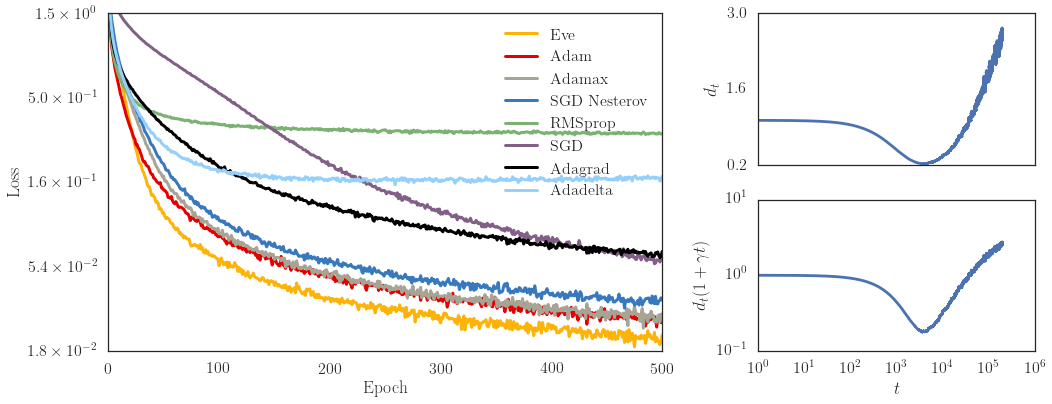

In [5]:
generic_visualize("cnn", "cifar10", nolrg=True, saveax1="../data/paper_figures/cnn_cifar10.eps")

### Detailed $d$ history

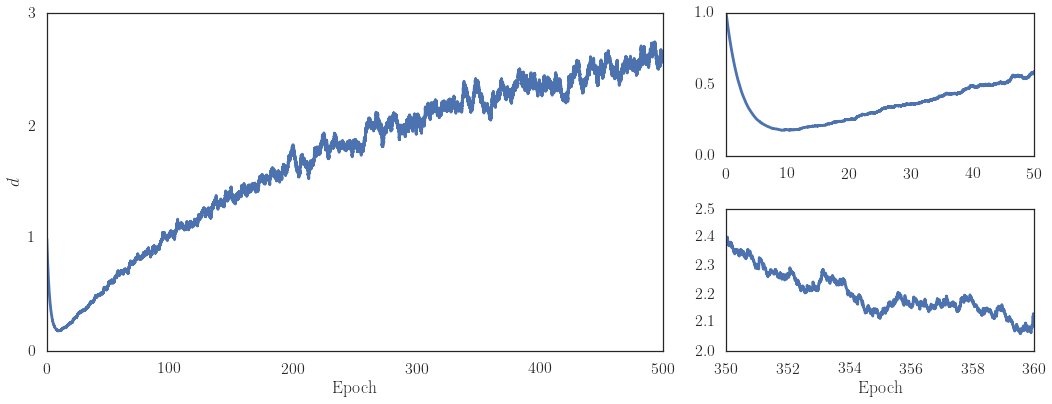

In [6]:
fig = plt.figure(figsize=(15, 6))
gs = gridspec.GridSpec(2, 2, width_ratios=[2, 1])
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 1])

with open("../data/cnn/cifar10/eve.pkl", "rb") as f:
    eve_ds = np.array([x.item() for x in pickle.load(f)["ds"]])
epoch_nums = np.arange(1, len(eve_ds) + 1) * 128. / 50000

ax1.plot(epoch_nums, eve_ds)
ax1.set_xlim(0, 500)
ax1.set_ylim(0, 3)
ax1.set_yticks([0, 1, 2, 3])
ax1.set_xlabel("Epoch")
ax1.set_ylabel("$d$")

ax2.plot(epoch_nums[epoch_nums <= 50], eve_ds[epoch_nums <= 50])
ax2.set_xlim(0, 50)
ax2.set_ylim(0, 1)
ax2.set_yticks([0, 0.5, 1.0])

ax3_epoch_range = np.bitwise_and(epoch_nums >= 350, epoch_nums <= 360)
ax3.plot(epoch_nums[ax3_epoch_range], eve_ds[ax3_epoch_range])
ax3.set_xlim(350, 360)
ax3.set_ylim([2., 2.5])
ax3.set_xlabel("Epoch")

fig.tight_layout()
plt.savefig("../data/paper_figures/d_history.eps", bbox_inches="tight", dpi=200)

### Minibatch loss history

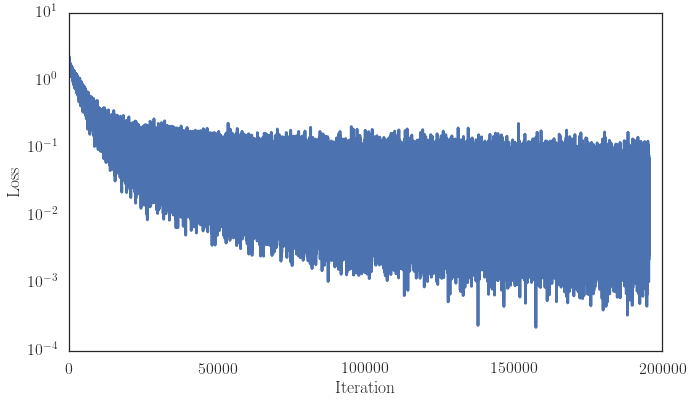

In [7]:
fig = plt.figure(figsize=(10, 6))
with open("../data/cnn/cifar10/eve.pkl", "rb") as f:
    batch_loss_history = pickle.load(f)["best_batch_loss_history"]
plt.semilogy(batch_loss_history)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.tight_layout()
plt.savefig("../data/paper_figures/cnn_cifar10_eve_minibatch_losses.eps")

## Big CNN CIFAR100

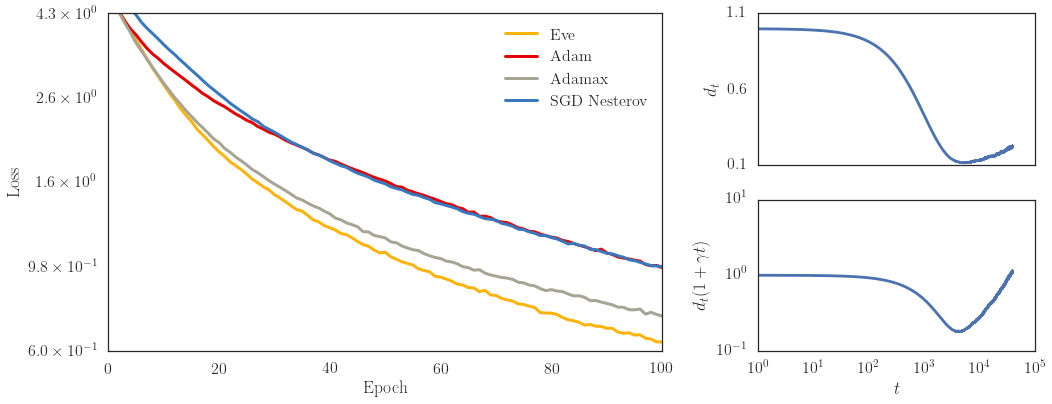

In [8]:
generic_visualize("big_cnn", "cifar100", nolrg=True, saveax1="../data/paper_figures/big_cnn_cifar100.eps")

# RNN Experiments

## Language Model

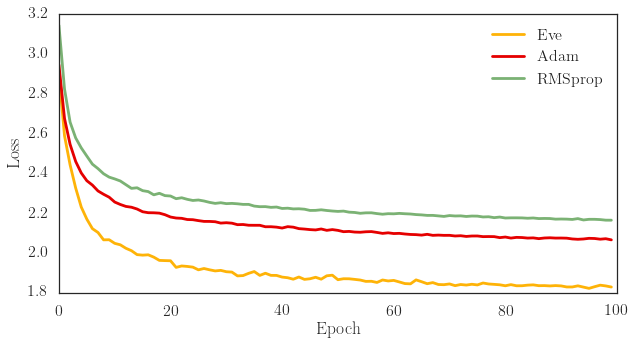

In [9]:
plt.figure(figsize=(10, 5))
for alg, alg_name, color in zip(["eve", "adam", "rmsprop"], ["Eve", "Adam", "RMSprop"], [colors[0], colors[1], colors[4]]):
    with open("../data/gru/ptb/{}/fitstats/epoch_losses.pkl".format(alg), "rb") as f:
        plt.plot(pickle.load(f)["train"], label=alg_name, color=color)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig("../data/paper_figures/gru_ptb.eps", dpi=200, bbox_inches="tight")

## BABI Q19

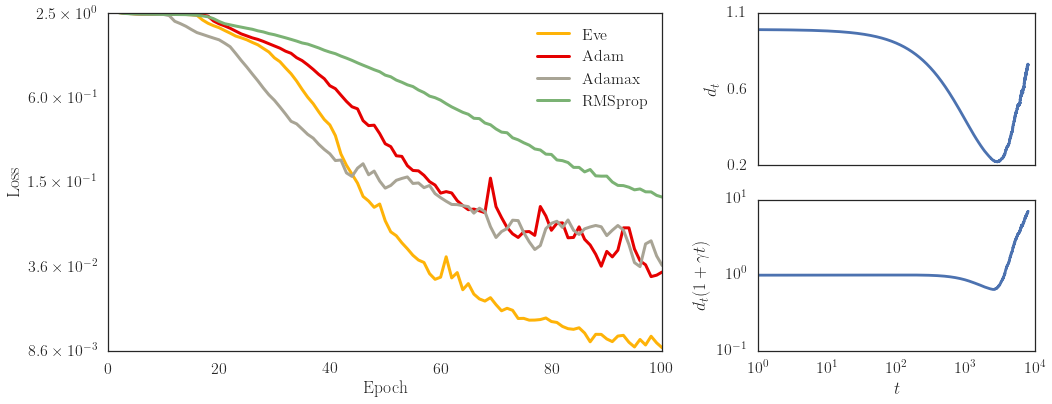

In [10]:
generic_visualize("gru", "babi_q19", saveax1="../data/paper_figures/gru_babi_q19.eps", nolrg=True)

## BABI Q14

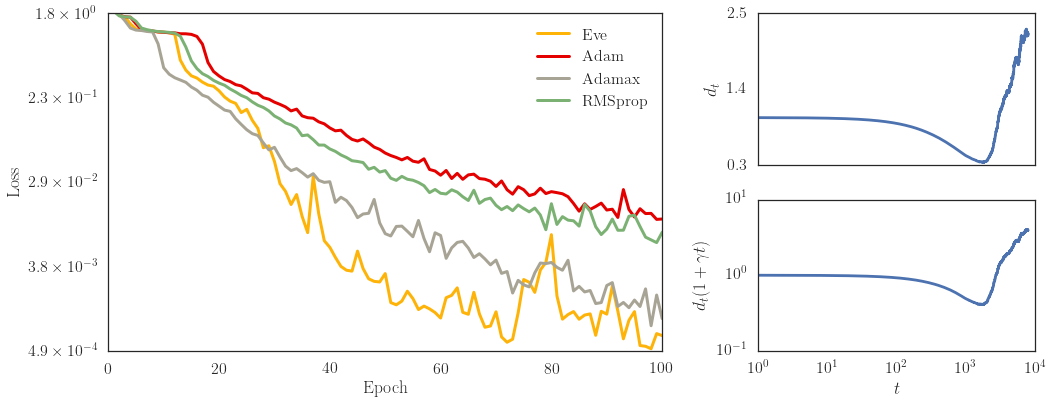

In [11]:
generic_visualize("gru", "babi_q14", saveax1="../data/paper_figures/gru_babi_q14.eps", nolrg=True)

## BABI Q6

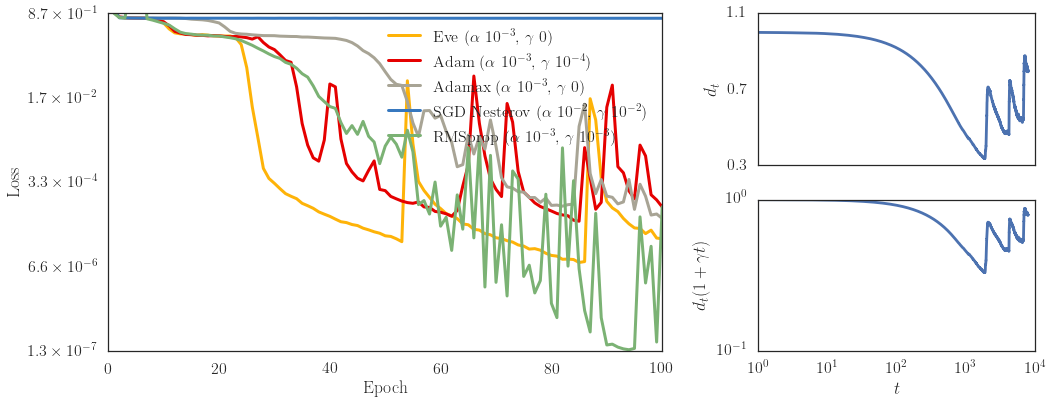

In [12]:
generic_visualize("gru", "babi_q6")

# Batch Logistic Regression Experiments

## MNIST

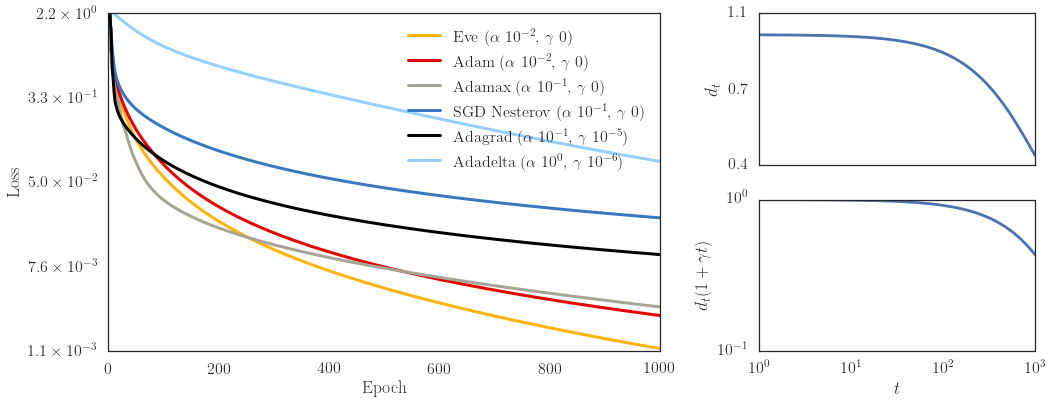

In [13]:
generic_visualize("batch_logistic", "mnist")

## CIFAR10

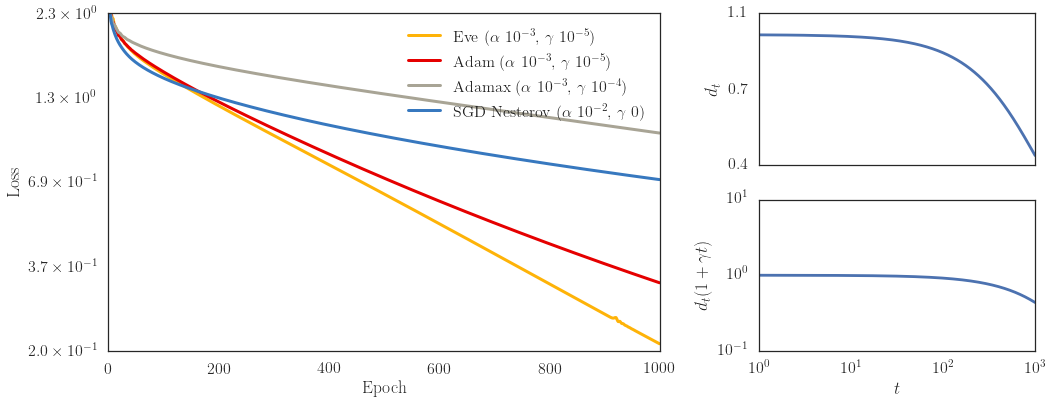

In [14]:
generic_visualize("batch_logistic", "cifar10")

## CIFAR100

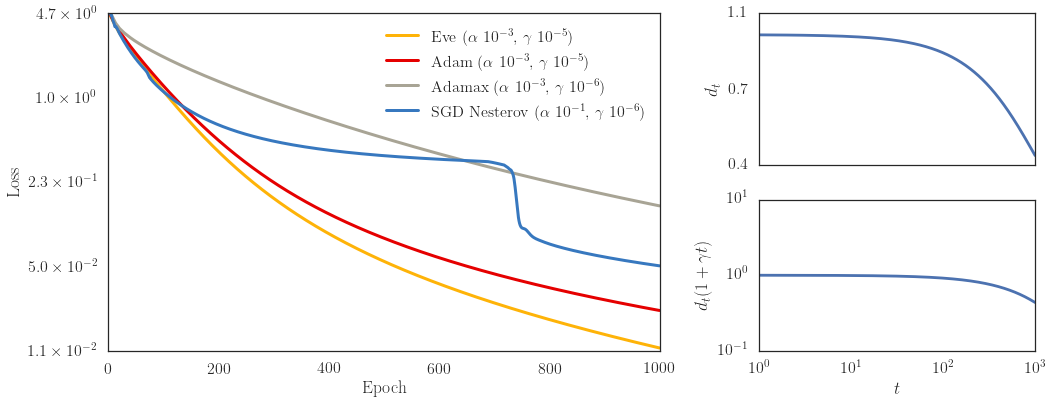

In [15]:
generic_visualize("batch_logistic", "cifar100")

# Logistic Regression Experiments

## MNIST

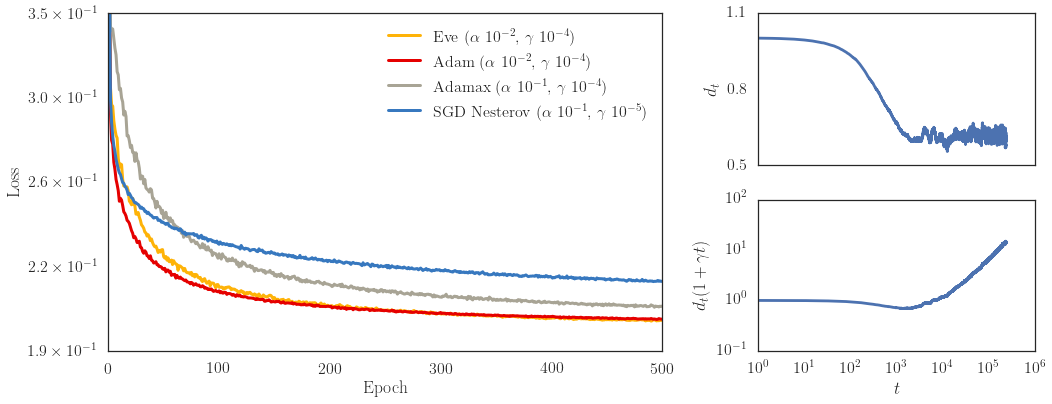

In [16]:
generic_visualize("logistic", "mnist")

## CIFAR10

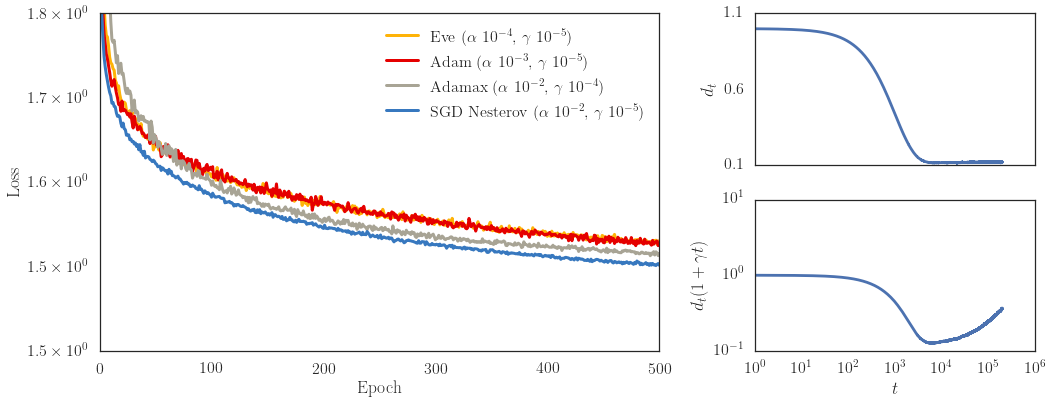

In [17]:
generic_visualize("logistic", "cifar10")

## CIFAR100

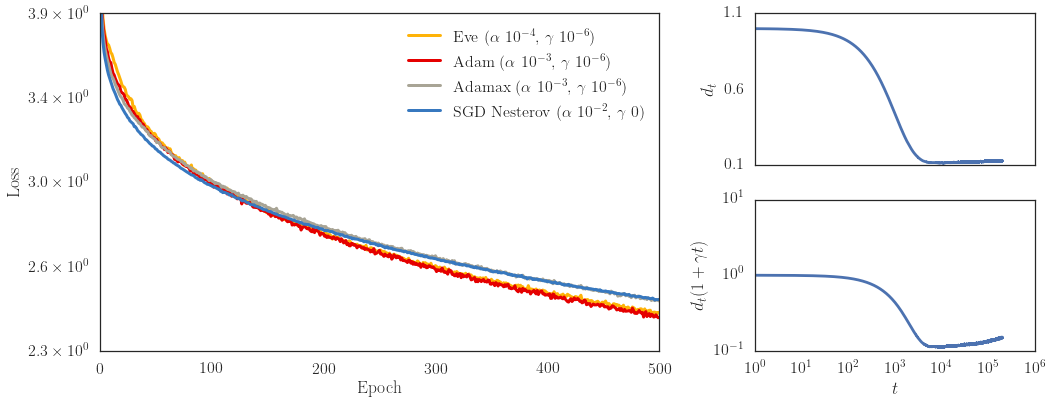

In [18]:
generic_visualize("logistic", "cifar100")

# MLNN Experiments

# MNIST

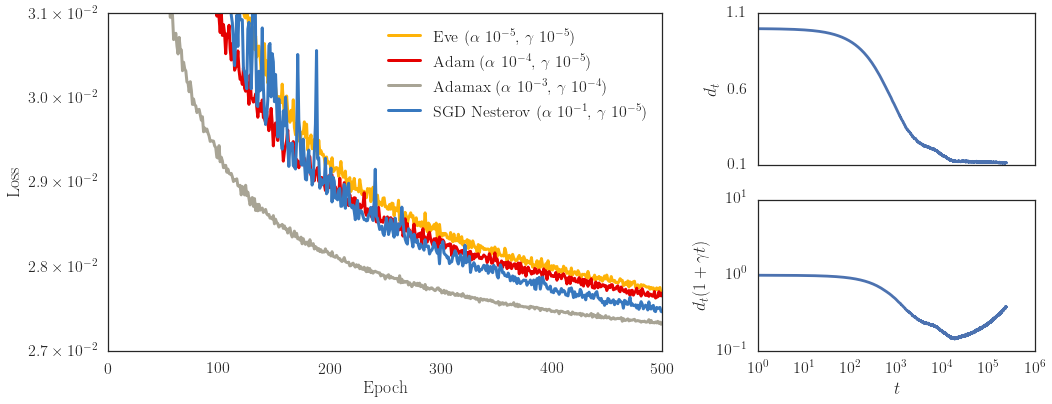

In [19]:
generic_visualize("mlnn", "mnist", (.027, .031))

# CIFAR10

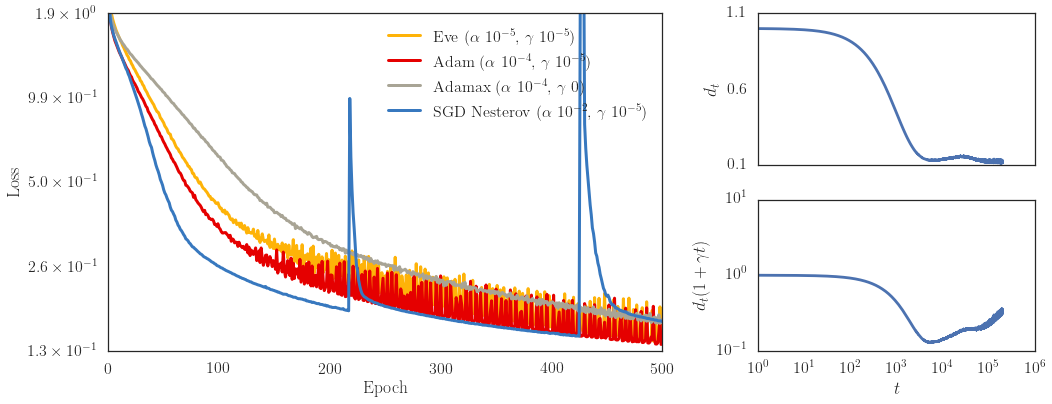

In [20]:
generic_visualize("mlnn", "cifar10")

## CIFAR100

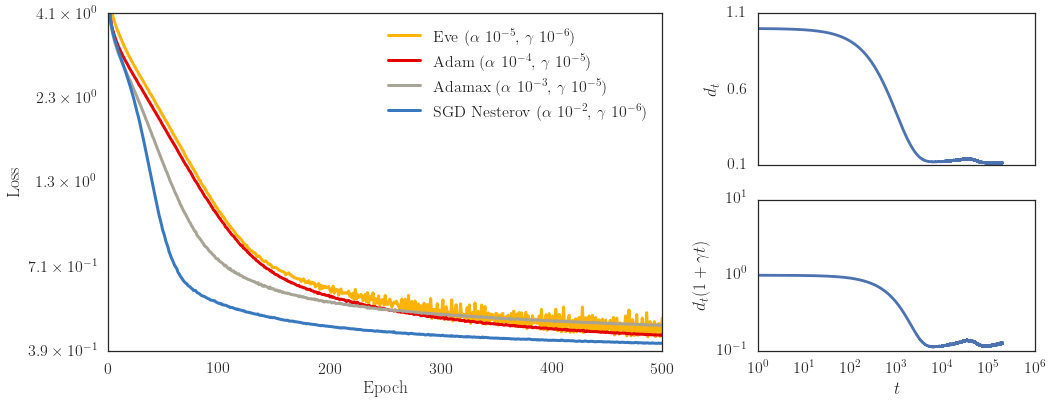

In [21]:
generic_visualize("mlnn", "cifar100")